
# **Selección de características en modelos predictivos**

## Inteligencia Artificial (IS) 2019/20 – Trabajo

### Autores: Eduardo Miguel Botía Domingo e Isaac Muñiz Valverde

En el presente fichero notebook, pretendemos mostrar de manera pormenorizada y detallada, en primer lugar, la implementación que se ha llevado a cabo para realizar el trabajo, para posteriormente mostrar pruebas utilizando los conjuntos de prueba proporcionados por el profesor tutor del proyecto.

## Importación de librerías y paquetes externos

### Importación de los ficheros con las funciones desarrolladas

Para llevar a cabo las funciones que serán expuestas en el presente notebook, se necesitan importar una serie de librerías y recursos que exponemos a continuación

In [2]:
import numpy
import pandas
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import multiprocessing

Analizamos cada una de las importaciones que llevamos a cabo

- NumPy : Se trata de un paquete de Phyton utilizado para realizar cálculo científico. Será utilizado en diversas ocasiones a lo largo de la implementación.

- Pandas : Se trata de un paquete de Phyton que es utilizado para el análisis de datos, lectura de ficheros fuente de información, y el tratamiento de dicha información, que será la procesada por el algoritmo.

- Matplotlib : Se trata de una librería que nos facilitará generar  representaciones gráficas para los datos que nos interese representar, como la relación de acierto con respecto a las variables escogidas.

- joblib y multiprocessing : Se trata de dos librerías que buscan facilitar a un alto nivel la paralelización y ejecución en paralelo de código. Resulta indispensable para realizar la paralelización en algunas zonas de la implementación, y debe además importarse e instalarse en el equipo desde Anaconda, así como ocurría con otras importaciones.

Las siguientes importaciones son acerca del paquete _scikit-learn_, también conocido como _sklearn_, que contienen funciones e implementaciones para el trabajo con aprendizaje automático en este lenguaje. Es de código abierto, construído sobre NumPy y es usado en múltiples aplicaciones dentro de su especialidad.

- preprocessing : Se trata de una operación de preprocesamiento, como su nombre indica, que ofrece al usuario la posibilidad de transformar los datos con los que va a trabajar el algoritmo en números enteros, dependiendo de la naturaleza de la variable. En nuestro caso, es utilizado para transformar las variables objetivo como booleanas.

- cross_val_score : Se trata de la implementación que nos ofrece el paquete _sklearn_ con el fin de realizar un experimento de validación cruzada para obtener una tasa de aciertos del algoritmo que le proporcionemos como parámetro, por defecto, de árboles. En este trabajo se desea por defecto, como veremos posteriormente en la implementación, la tasa de aciertos balanceada.

- DecisionTreeClassifier : Se trata de un algoritmo implementado en la librería, que construye árboles binarios. Será el método evaluado por la validación cruzada sobre los datos.

***

## Implementación

### Implementación del método de evaluación 

Como parte fundamental y utilizada por los procedimientos objetivo de este trabajo, SFS, de búsqueda secuencial hacia adelante y SFFS, de búsqueda mixta hacia adelante como estrategia primaria y hacia atrás; en primer lugar, debe diseñarse la implementación de un método de evaluación robusta, el cual se basa en una validación cruzada, cuyo fundamento se encuentra explicado más detalladamente en la documentación adscrita a este trabajo. 

Básicamente, buscamos implementar un algoritmo que realice una evaluación basada fundamentalmente en la tasa de acierto y error producidos por un algoritmo de aprendizaje automático utilizando un conjunto de variables reducido con respecto al original. Gracias a él, podremos saber si un conjunto de variables es mejor o peor que otro, lo cual es necesario para la implementación de dichos algoritmos.

En lo que respecta a la implementación, pasamos a explicarla paso por paso mediante comentarios en la implementación del algoritmo.

En primera instancia, debemos introducir como parámetros del método
 
- datos : conjunto de datos procesados de origen externo utilizando la librería Pandas.
 
- variablesEscogidas : conjunto de variables del conjunto de datos original que pretendemos evaluar, para averiguar su eficacia al aplicar un algoritmo de aprendizaje sobre él.

- N_exp : número de veces que repetiremos el experimento, para obtener una evaluación más adecuada y equilibrada, a costa de una mayor complejidad.

- CV : número de pliegues que realizará el algoritmo de validación cruzada sobre el conjunto de datos original. Se realizará ese número de veces de estimaciones, dividiendo el conjunto de pruebas por ese mismo número, siendo uno de prueba y el resto de entrenamiento.

- estimador: de manera adicional a la propuesta del trabajo, se añade la posibilidad algoritmo de aprendizaje automático deseado por el usuario. Por defecto, se utilizará el árbol de decisión binario.

- métrica_evaluación: nos permitirá modificar la métrica de evaluación a usar. Es opcional, ya que por defecto utiliza 'balanced_accuracy'

In [3]:
def evaluar_solucion(datos, variablesEscogidas, N_exp, CV=10, estimador=DecisionTreeClassifier(), métrica_evaluación='balanced_accuracy'):
    
    #Datos
    nombres_propiedades = datos.columns;

    #Selección de la variable objetivo, para su posterior procesado como labelEncoder.
    #La selección de este procesado es porque se trata de una variable booleana, con únicamente 2 posibilidades, por lo que este procesado lo normaliza.
    objetivo = datos[nombres_propiedades[-1]]
    codificador_objetivo = preprocessing.LabelEncoder()
    objetivo_codificado = codificador_objetivo.fit_transform(objetivo)
    
    #Se realiza un control de que las variables escogidas por el usuario, para comprobar que el conjunto de variables escogidas no contenga la variable sobre la que se toma la decisión.
    if nombres_propiedades[-1] in variablesEscogidas:
        return 'variables no válidas'
    
    #Creamos un nuevo conjunto con las columnas seleccinadas por el usuario 
    tabla_columnas_seleccionadas = datos[variablesEscogidas]
    
    #Ejecución
    #1. Seleccionar del conjunto de datos de entrada, el subconjunto de columnas (variables) que queremos evaluar
    #2. Repetir N_Exp veces y promediar el resultado:
    #    2.1. Realizar experimento de valización cruzada (siendo CV el número de folds) mediante la función ‘cross_val_score’
    
    
    #Inicializamos el conjunto con las puntuaciones sucesivas obtenidas
    #Inicializamos el contador de iteraciones sobre el bucle que iterará para obtener los número de experimentos deseados.
    puntuaciones = []
    contador = 0
    
    #Creamos un bucle que ejecutará el número de experimentos solicitados por el usuario.
    while (contador < N_exp):
        #Por cada experimento, ejecutaremos la función de validación cruzada utilizando un árbol sobre la tabla con los datos seleccionados.
        #Como objetivo(y), le pasaremos la columna objetivo.
        #Como método de puntuación, por defecto, balanced_accuracy.
        #Como número de pliegues el que nos ha facilidtado el usuario.
        #Definimos que de ocurrir un error al evaluar, se lanzará una excepción, para no distorsionar los datos. 
        puntuaciones.append(cross_val_score(estimador, tabla_columnas_seleccionadas, y=objetivo_codificado, scoring=métrica_evaluación, cv=CV, error_score='raise', n_jobs=-1))
        contador += 1
    
    #inicializo variable para calcular la media
    media = 0;

    #Bucle para calcular la suma de todas las puntuaciones y después dividirlas, incluyendo pliegues y las repeticiones, para obtener la media de todas las estimaciones totales.
    for i in range(len(puntuaciones)):
        for j in range(len(puntuaciones[i])):
            media=media+puntuaciones[i][j]

            
    media=media/(N_exp*CV)
    
    #Devolvemos la media
    return media

Con el objetivo de optimizar el funcionamiento y rendimiento de este algoritmo, y aún más importante, de todos los que basan buena parte de su funcionamiente y lo utilizan posteriormente, se procede a mostrar la modificación llevada a cabo sobre la anterior función para realizar paralelización en el bucle que realiza la validación cruzada.

In [4]:
def evaluar_solucion_paralelizada(datos, variablesEscogidas, N_exp, CV=10, estimador=DecisionTreeClassifier(), métrica_evaluación='balanced_accuracy'):
    
    #Datos
    nombres_propiedades = datos.columns;

    #Selección de la variable objetivo, para su posterior procesado como labelEncoder.
    #La selección de este procesado es porque se trata de una variable booleana, con únicamente 2 posibilidades, por lo que este procesado lo normaliza.
    objetivo = datos[nombres_propiedades[-1]]
    codificador_objetivo = preprocessing.LabelEncoder()
    objetivo_codificado = codificador_objetivo.fit_transform(objetivo)
    
    #Se realiza un control de que las variables escogidas por el usuario, para comprobar que el conjunto de variables escogidas no contenga la variable sobre la que se toma la decisión.
    if nombres_propiedades[-1] in variablesEscogidas:
        return 'variables no válidas'
    
    #Creamos un nuevo conjunto con las columnas seleccinadas por el usuario 
    tabla_columnas_seleccionadas = datos[variablesEscogidas]
    
    #Ejecución
    #1. Seleccionar del conjunto de datos de entrada, el subconjunto de columnas (variables) que queremos evaluar
    #2. Repetir N_Exp veces y promediar el resultado:
    #    2.1. Realizar experimento de valización cruzada (siendo CV el número de folds) mediante la función ‘cross_val_score’
    
    
    #Inicializamos el conjunto con las puntuaciones sucesivas obtenidas
    #Inicializamos el contador de iteraciones sobre el bucle que iterará para obtener los número de experimentos deseados.
    puntuaciones = []
    contador = 0
    
    #Obtenemos el número de procesadores con los que cuenta el equipo del ordenador donde se va a ejecutar el algoritmo.
    número_procesadores = multiprocessing.cpu_count()
    
    #A continuación, utilizando la librería que describimos anteriormente, realizamos el bucle de forma paralelizada.
    #Para ello, definimos el número de procesadores, la cantidad de información que se muestra al usuario en primer lugar.
    #Después, en delayed, especificamos la función que queremos paralelizar, para posteriormente, especificar los parámetros que va a utilizar.
    #Finalmente, especificamos las iteraciones que queremos llevar a cabo, hasta el número de experimentos que ha especificado el usuario.
    puntuaciones = Parallel(n_jobs=número_procesadores, verbose=0)(delayed(cross_val_score )(estimador, tabla_columnas_seleccionadas, y=objetivo_codificado, scoring=métrica_evaluación, cv=CV, error_score='raise', n_jobs=-1)for i in range(0, N_exp))

    #inicializo variable para calcular la media
    media = 0;

    #Bucle para calcular la suma de todas las puntuaciones y después dividirlas, incluyendo pliegues y las repeticiones, para obtener la media de todas las estimaciones totales.
    for i in range(len(puntuaciones)):
        for j in range(len(puntuaciones[i])):
            media=media+puntuaciones[i][j]

            
    media=media/(N_exp*CV)
    
    #Devolvemos la media
    return media

### Implementación de la Sequential Forward Selection

Con la idea de conseguir un conjunto de las mejores variables, que predigan mejor el resultado, utilizaremos un algoritmo de búsqueda, conocido como Sequential Forward Selection, o SFS, que obtiene buenos resultados sin tener que recurrir a metodos de complejidad exponencial, como la búsqueda exhaustiva.


Comenzando por un conjunto de variables, trata de escoger la mejor variable diferente a las que ya contiene, para ello, evalúa todas aquellas candidatas mediante el método de evaluación robusto que hemos presentado anteriormente. Partiendo de un conjunto vacío, finalmente obtendrá como salida una tabla con las mejores variables, su puntuación, y su tamaño, que es definido por el número de sus variables.

Para ello, debemos pasarle el conjunto de datos con las propiedades que desean probarse y la variable objetivo en última posición, seleccionados sobre el conjunto de datos original. Además, deberá facilitarse el número de variables que desean ser probadas del conjunto de datos, por si se desea probar un subconjunto menor. Por defecto , este parámetro será igual a la longitud de propiedades del conjunto de datos, con el fin de que realice el proceso con todas las variables. A su vez, también se le pueden pasar de forma opcional los parámetros que nombramos anteriormente, para decidir el algoritmo de aprendizaje y la métrica de evaluación deseada.

En este caso presentamos 2 funciones, uno que devuelve los datos en forma de lista, para una mayor precisión o reutilización de los datos, o bien otra función, que devuelve una tabla con esta información.

Procedemos a mostrar la implementación explicada paso por paso.

In [5]:
def sequential_forward_selection(datos_seleccionados, D=0, estimador=DecisionTreeClassifier(), métrica_evaluación='balanced_accuracy'):

    #Inicialización    
    #Obtenemos todas las propiedades de los datos que nos pasan como parámetro.
    nombres_propiedades = datos_seleccionados.columns;
    
    #Comprobamos si el usuario nos ha pasado un parámetro, en cuyo caso lo dejamos, pero en caso contrario, definimos que recorra todas las variables del conjunto.
    if(D==0):
        D=len(nombres_propiedades)-1


    #SolucionActual: Almacena el mejor conjunto de variables obtenido en cada iteración. Inicialmente está vacío.
    SolucionActual = []

    #K=0. K es el contador de iteraciones o de variables seleccionadas en cada iteración.
    K=0
    
    #Ejecución
    #Inicializamos la lista que devolvemos como respuesta, sobre la que añadiremos el conjunto de soluciones.
    lista_soluciones = [] 
    #Inicializamos la lista con las variables que va seleccionando el algoritmo.
    SolucionActual = []
    #Mientras que K<D
    while(K<D):
        #1. Seleccionar la mejor variable para añadir a SolucionActual. Por cada variable V del conjunto original de variables que no se encuentre en SolucionActual:
        #1.1. SolucionTemporal = SolucionActual + V
        #Inicializamos un contador para iterar sobre todas las variables que podemos añadir al actual conjunto, para evaluar cual sería su evaluación y quedarnos con la mejor.
        i=0
        #Inicializamos dos variables para almacenar la mejor posibilidad recogida hasta el momento, para compararlas con las siguientes, y quedarnos con la mejor.
        mejor_evaluacion = 0
        MejorSolucionTemporal = []
        
        #Iterador sobre todas las posibilidades de variables que podemos añadir
        while(i<len(nombres_propiedades)-1):
            
            #Seleccionamos la variable sobre la que trabajamos y la añadimos al conjunto de prueba a evaluar.
            V = nombres_propiedades[i]
        
            SolucionTemporal = SolucionActual.copy()
            SolucionTemporal.append(V)          
            
            #Evaluamos las variables seleccionadas, 
            evaluacion_temporal = evaluar_solucion_paralelizada(datos_seleccionados, SolucionTemporal, 20, 10, estimador, métrica_evaluación)
            i=i+1
            
            #Penalizamos que la variable ya se encuentre previamente en la solución. 
            if V in SolucionActual:
                evaluacion_temporal=0
            
            #Comprobamos si el resultado de hacer la evaluación ha sido superior a la máxima anterior. En caso positivo, la almacenamos como la mejor.
            if(evaluacion_temporal>mejor_evaluacion):
                MejorSolucionTemporal=SolucionTemporal
                mejor_evaluacion = evaluacion_temporal
                
        
        #Una vez que hemos recorrido y evaluado todas las posibilidades, nos quedamos con la mejor y la añadimos al conjunto con las soluciones.
        solucion_k = [MejorSolucionTemporal, len(MejorSolucionTemporal), mejor_evaluacion]
        lista_soluciones.append(solucion_k)
        
        SolucionActual = MejorSolucionTemporal
        K=K+1
    
    #Al final del algoritmo, devolvemos la lista de soluciones.
    return lista_soluciones

### Implementación de la Sequential Floating Forward Selection

Como alternativa al método anterior, utilizaremos un algoritmo de búsqueda más avanzado, secuencial mixto que combina la estrategia hacia adelante que utilizamos con el algoritmo SFS, y atrás como secundaria. 

Su implementación es muy similar al SFS, con la adición de una evaluación que nos permitirá conocer si resulta más óptimo realizar la adición o eliminación. Para compararlo, evaluaremos ambas posibilidades utilizando el método de evaluación robusto que presentamos anteriormente. Como diferencia, este algoritmo puede tener la circunstancia de que una vez se han añadido todas las variables, quizá resulta óptima la solución de eliminar una variable, por lo que no puede acabar cuando se han recorrido todas las variables. En lugar de ello, debemos establecer una condición de parada que consista en que, efectivamente, todas las variables hayan sido tratadas por el algoritmo, y que hayan pasado un número concreto de evaluaciones adicionales para que el algoritmo "tenga tiempo" de eliminar las variables que resulten prescindibles.

En este caso presentamos 2 funciones, uno que devuelve los datos en forma de lista, para una mayor precisión o reutilización de los datos, o bien otra función, que devuelve una tabla con esta información.

Procedemos a mostrar la implementación explicada paso por paso.

In [6]:
def sequential_floating_forward_selection(datos_seleccionados, estimador=DecisionTreeClassifier(), métrica_evaluación='balanced_accuracy'):
    
    nombres_propiedades = datos_seleccionados.columns;
    
    #Inicialización:
    #• SolucionActual: Almacena el mejor conjunto de variables obtenido en cada iteración. Inicialmente está vacío.
    SoluciónActual = []
    #• Añadidos: Almacena las variables que ya han sido añadidas.
    Añadidos = []
    #• Eliminados: Almacena las variables que han sido elimnadas.
    Eliminados = []
    #• K=0. K es el contador de iteraciones o de variables seleccionadas en cada iteración
    K=0

    #Almacena la mejor evaluación entre añadir y eliminar
    mejor_evaluacion = 0

    #Solución que va a ser devuelta
    lista_soluciones = [] 
    
    #Condición de parada que dictará cuando acaben las iteraciones del algoritmo.
    CondicionDeParada = False
    #Contador de iteraciones del algoritmo sin que haya ejecutado ninguna eliminación, es otra condición para la parada del algoritmo como observaremos posteriormentes.
    iteraciones_sin_eliminar=0;

    #Ejecución
    #Mientras que no se dé la condición de parada.
    while(not CondicionDeParada):
    #---------AÑADIR MEJOR VARIABLE---------
    #1. Seleccionar la mejor variable para añadir a SolucionActual. Por cada variable V del conjunto original de variables que no se encuentre en SolucionActual ni en Añadidos:
    #1.1. SolucionTemporal = SolucionActual + V
    #1.2. Evaluar SolucionTemporal y guardar su rendimiento.
        K=K+1
        #Para recorrer el bucle de propiedades en cada iteración
        i=0
        #Almacena la mejor evaluación en la adición de la mejor variable
        mejor_evaluacion_añadir = 0
        #Almacena hasta el momento la mejor solución en cada iteración
        MejorSolucionTemporal = []
        #Almacena la mejor variable tras haver realizado la adición
        mejor_variable = nombres_propiedades[0]
        
        #De manera análoga al algoritmo SFS evaluamos la posibilidad de añadir una variable
        while(i<len(nombres_propiedades)-1):

            V = nombres_propiedades[i]

            SolucionTemporal = SoluciónActual.copy()
            SolucionTemporal.append(V)

            evaluacion_temporal = evaluar_solucion_paralelizada(datos_seleccionados, SolucionTemporal, 1, 5, estimador, métrica_evaluación)
            i=i+1

            if V in SoluciónActual:
                evaluacion_temporal=0
            
            #Además de la penalización anterior, en este caso, debemos penalizar que la variable evaluada no estuviese en el conjunto de las ya visitadas.
            if V in Añadidos:
                evaluacion_temporal=0

            if(evaluacion_temporal>mejor_evaluacion_añadir):
                MejorSolucionTemporal=SolucionTemporal
                mejor_evaluacion_añadir = evaluacion_temporal
                mejor_variable = V

        #2. Seleccionar la mejor SoluciónTemporal (la que proporcione mayor rendimiento) y hacer
        if(len(MejorSolucionTemporal)>0):
            mejor_evaluacion = mejor_evaluacion_añadir
            SoluciónActual = MejorSolucionTemporal     
            #3. Actualizar Añadidos: Añadimos a esta lista la nueva variable añadida a SoluciónActual.
            Añadidos.append(mejor_variable)
        
        #Segunda parte, ahora probamos la eliminación de una variable, por si mejorase el rendimiento.
        #---------ELIMINAR LA PEOR VARIABLE (SOLO SI HAY MEJORA)---------
        #4. Seleccionar la peor variable para eliminar de SolucionActual. Por cada variable V de SolucionActual que no se encuentre en Eliminados:
        #4.1. SolucionTemporal = SolucionActual – V
        #4.2. Evaluar SolucionTemporal y guardar su rendimiento
        
        #El procedimiento es similar a la adición, pero con algunas diferencias que vamos a presentar.
        j=0    
        mejor_evaluacion_eliminar = 0
        MejorSolucionTemporal = []
        mejor_variable = SoluciónActual[0]
        
        #En lugar de iterar sobre las variables de los datos, lo hacemos sobre las variables que hemos añadido, que son las que queremos optimizar.
        while(j<len(SoluciónActual)-1):        
            V = SoluciónActual[j]
            
            #Probamos a eliminar una variable del conjunto para evaluar su rendimiento.
            SolucionTemporal = SoluciónActual.copy()
            SolucionTemporal.remove(V)          

            evaluacion_temporal = evaluar_solucion_paralelizada(datos_seleccionados, SolucionTemporal, 1, 5, estimador, métrica_evaluación)
            j=j+1
            
            #Por defecto, aumentamos el contador de iteraciones sin eliminar, en caso de finalmente realizarse, posteriormente lo pondremos a 0.
            iteraciones_sin_eliminar = iteraciones_sin_eliminar+1
            
            #Al contrario que el caso anterior, en este caso, debemos comprobar que la variable que deseamos elimninar no la hayamos eliminado previamente.
            if V in Eliminados:
                evaluacion_temporal=0
            
            #A lo largo de las iteraciones nos vamos quedando con la solución que nos ofrezca una mejor puntuación.
            if(evaluacion_temporal>mejor_evaluacion_eliminar):
                MejorSolucionTemporal=SolucionTemporal
                mejor_evaluacion_eliminar = evaluacion_temporal
                mejor_variable = V
        
        #5. Seleccionar la mejor SoluciónTemporal (la que proporcione mayor rendimiento). Solo si el rendimiento de la mejor Solución temporal es superior al rendimiento de la mejor solucion obtenida en el punto 2, entonces: SoluciónActual = MejorSolucionTemporal. En este caso, actualizar Eliminados añadiendo la variable eliminada.
        if(mejor_evaluacion_eliminar>mejor_evaluacion):
            SoluciónActual = MejorSolucionTemporal     
            Eliminados.append(mejor_variable)
            iteraciones_sin_eliminar=0
            mejor_evaluacion = mejor_evaluacion_eliminar

        #6. Evaluar condición de parada (se detalla a continuación)
        #La condición de para solo puede ser cierta una vez que todas las variables han sido procesadas por el proceso de adición, es decir, Añadidos contiene todas las variables originales.
        if((len(Añadidos)==(len(nombres_propiedades)-1)) and iteraciones_sin_eliminar>10):
            CondicionDeParada = True

        #Añadimos a la lista de soluciones la mejor solución que hayamos obtenido en esta iteración.
        solucion_k = [SoluciónActual, len(SoluciónActual), mejor_evaluacion]
        lista_soluciones.append(solucion_k)
    #Devolver tabla con cada una de las MejorSolucionTemporal (obtenida al final de cada iteración), el tamaño y el rendimiento de cada una.        
    return lista_soluciones

***

## Pruebas y experimentos

### Conjuntos de pruebas, importación y tratamiento 

Para realizar pruebas sobre los algoritmos, así como realizar experimientos, utilizaremos como fuente diferentes conjuntos de datos proporcionados por la propuesta de trabajo, que se encuentran preprocesados.

Para importarlos, utilizaremos la librería de tratamiento de datos Pandas, y utilizaremos el DataFrame que genera como fuente de información que utilizar en los algoritmos que vamos a probar.

En primer lugar importaremos el conjunto de datos de pasajeros del Titanic, para luego hacer lo mismo con el conjunto de datos relativos al cáncer de mama.

In [7]:
full_titanic_passangers = pandas.read_csv('titanic.csv', header=0)
full_breast_cancer_cases = pandas.read_csv('BreastCancerDataset.csv', header=0)

### Pruebas de procedimientos individuales: método de evaluación 

En primer lugar, vamos a probar a ejecutar el método de evaluación sobre los conjuntos de datos, para comprobar su funcionamiento básico.


#### Conjunto de datos: Titanic
En primer lugar, probaremos el conjunto completo, para ir a posteriori reduciendo el número de variables y comprobar sus resultados.

In [8]:
todas_variables_titanic=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Initial','Age_band','Family_Size','Alone','Fare_cat','Deck','Title','Is_Married']
print(evaluar_solucion_paralelizada(full_titanic_passangers, todas_variables_titanic, 20, 10))

0.7710349079025548


In [9]:
tres_variables_titanic=['Embarked','Age_band','Family_Size']
print(evaluar_solucion_paralelizada(full_titanic_passangers, tres_variables_titanic, 20, 10))

0.6190617661205894


In [10]:
una_variable_titanic=['Age_band']
print(evaluar_solucion_paralelizada(full_titanic_passangers, una_variable_titanic, 20, 10))

0.5403229776759183


A continuación, vamos a probar un caso especial que rompe la norma general, ya que muestra con un número menor de variables, una mayor tasa de acierto que en los casos anteriores, con más variables. Este experimento pertenece a la documentación, y podemos extraer de ella las conclusiones que hemos extraído de ella.

In [11]:
una_variable_titanic=['Initial']
print(evaluar_solucion_paralelizada(full_titanic_passangers, una_variable_titanic, 20, 10))

0.7833541295305997


#### Conjunto de datos: Tumores
De igual manera que en el caso anterior, en primer lugar, probaremos el conjunto completo, para ir a posteriori reduciendo el número de variables y comprobar sus resultados.

In [12]:
todas_variables_tumores=['mean radius','mean texture','mean perimeter','mean area','mean smoothness','mean compactness','mean concavity','mean concave points','mean symmetry','mean fractal dimension','radius error','texture error','perimeter error','area error','smoothness error','compactness error','concavity error','concave points error','symmetry error','fractal dimension error','worst radius','worst texture','worst perimeter','worst area','worst smoothness','worst compactness','worst concavity','worst concave points','worst symmetry','worst fractal dimension']
print(evaluar_solucion_paralelizada(full_breast_cancer_cases, todas_variables_tumores, 20, 10))

0.9085983044733041


In [13]:
tres_variables_tumores=['mean radius','mean texture','mean perimeter']
print(evaluar_solucion_paralelizada(full_breast_cancer_cases, tres_variables_tumores, 20, 10))

0.879220779220778


In [14]:
una_variable_tumores=['mean radius']
print(evaluar_solucion_paralelizada(full_breast_cancer_cases, una_variable_tumores, 20, 10))

0.7916919191919186


Un hecho que observamos ejecutando ambos conjuntos de prueba, es que aunque no tenga porque ocurrir así necesariamente, y probando con otras variables no se cumple como explicaremos posteriormente, como podemos observar, tiende a tener una menor tasa de acierto cuando reducimos el número de variables. 

Lógicamente, esto es causado porque el entrenamiento, con un mayor número de variables, ofrecerá una mayor precisión a la hora de obtener un resultado cuando existe una relación directa entre variables y variable objetivo.

Esta variabilidad que presenta incluso en ocasiones con mayor tasa de error con un mayor número de variables, es causada por la presencia de variables que introducen ruido en el entrenamiento y provocan una tasa de errores superior al ejecutar pruebas.

Estos factores dependerán del conjunto de entrenamiento y de las variables que han sido seleccionadas.

Por otra parte, otro factor determinante a la hora de ejecutar esta función es el parámetro de pliegues que realiza la validación cruzada. La razón para incluirlo en este algoritmo reside en que los métodos de aprendizaje suelen incluir una componente de aleatoreidad. En este caso, buscamos regularizar el método, por lo que utilizamos este preciso procedimiento, junto con, a voluntad del usuario, introducir una variable para repetir el conjunto de los experimentos todas aquellas iteraciones que se desee para hacer una media de los resultados de cada una de ellas, y así obtener un resultado promedio que haga que el resultado sea más preciso, a costa de una complejidad mucho mayor, y un tiempo mayor.

### Pruebas de procedimientos individuales: Sequential Forward Selection

Después de probar el mecanismo de evaluación anterior, vamos a probar a ejecutar el método de búsqueda secuencial hacia adelante sobre los conjuntos de datos, para comprobar su funcionamiento básico.


#### Conjunto de datos: Titanic
En primer lugar, probaremos el conjunto completo, para ir a posteriori reduciendo el número de variables y comprobar sus resultados.

In [15]:
todas_variables = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Initial','Age_band','Family_Size','Alone','Fare_cat','Deck','Title','Is_Married','Survived']#
datos_titanic_seleccionados = full_titanic_passangers[todas_variables]

procesamiento = sequential_forward_selection(datos_titanic_seleccionados)
nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(procesamiento, columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[Initial],1,0.783354
1,"[Initial, SibSp]",2,0.805218
2,"[Initial, SibSp, Deck]",3,0.807720
3,"[Initial, SibSp, Deck, Fare_cat]",4,0.809398
4,"[Initial, SibSp, Deck, Fare_cat, Title]",5,0.815833
5,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",6,0.815976
6,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",7,0.815333
7,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",8,0.809951
8,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",9,0.808486
9,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",10,0.804206


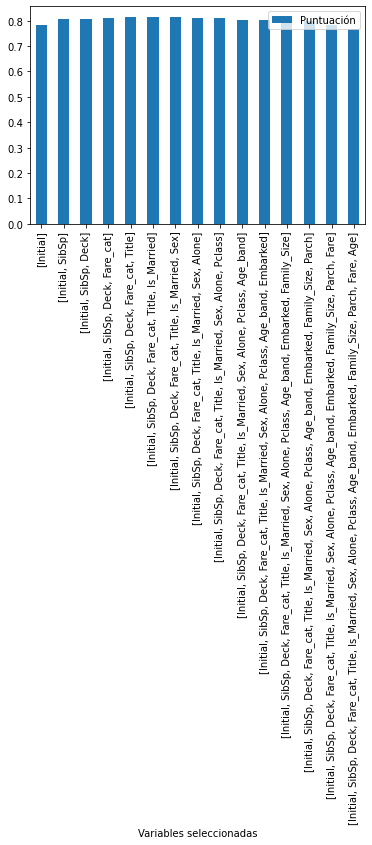

In [16]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

In [17]:
#Información que devuelve el algoritmo, sin procesar en una tabla o gráfico.
procesamiento

[[['Initial'], 1, 0.7833541295305997],
 [['Initial', 'SibSp'], 2, 0.8052182893359369],
 [['Initial', 'SibSp', 'Deck'], 3, 0.8077201991907876],
 [['Initial', 'SibSp', 'Deck', 'Fare_cat'], 4, 0.8093981976629041],
 [['Initial', 'SibSp', 'Deck', 'Fare_cat', 'Title'], 5, 0.8158328806269983],
 [['Initial', 'SibSp', 'Deck', 'Fare_cat', 'Title', 'Is_Married'],
  6,
  0.8159757377698554],
 [['Initial', 'SibSp', 'Deck', 'Fare_cat', 'Title', 'Is_Married', 'Sex'],
  7,
  0.8153328806269983],
 [['Initial',
   'SibSp',
   'Deck',
   'Fare_cat',
   'Title',
   'Is_Married',
   'Sex',
   'Alone'],
  8,
  0.809950527685822],
 [['Initial',
   'SibSp',
   'Deck',
   'Fare_cat',
   'Title',
   'Is_Married',
   'Sex',
   'Alone',
   'Pclass'],
  9,
  0.8084858670741022],
 [['Initial',
   'SibSp',
   'Deck',
   'Fare_cat',
   'Title',
   'Is_Married',
   'Sex',
   'Alone',
   'Pclass',
   'Age_band'],
  10,
  0.8042057691763567],
 [['Initial',
   'SibSp',
   'Deck',
   'Fare_cat',
   'Title',
   'Is_Married

In [18]:
pocas_variables = ['Pclass','Sex','Age','SibSp','Parch','Fare','Survived']#
pocos_datos_titanic_seleccionados = full_titanic_passangers[pocas_variables]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(sequential_forward_selection(pocos_datos_titanic_seleccionados),columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[Sex],1,0.766800
1,"[Sex, Fare]",2,0.785850
2,"[Sex, Fare, Pclass]",3,0.797516
3,"[Sex, Fare, Pclass, SibSp]",4,0.793174
4,"[Sex, Fare, Pclass, SibSp, Parch]",5,0.779274
5,"[Sex, Fare, Pclass, SibSp, Parch, Age]",6,0.759135


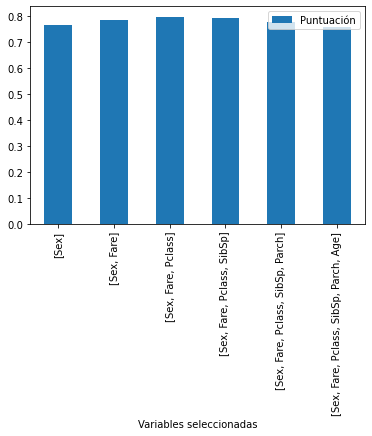

In [19]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

In [20]:
una_variable = ['Pclass','Survived']#
un_datos_titanic_seleccionado = full_titanic_passangers[una_variable]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(sequential_forward_selection(un_datos_titanic_seleccionado), columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[Pclass],1,0.626197


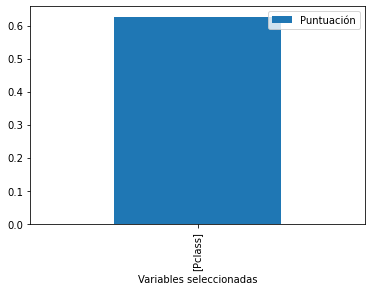

In [21]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

#### Conjunto de datos: Tumores
En segunda instancia, probaremos el conjunto completo, para ir a posteriori reduciendo el número de variables y comprobar sus resultados.

In [22]:
todas_variables_tumores=['mean radius','mean texture','mean perimeter','mean area','mean smoothness','mean compactness','mean concavity','mean concave points','mean symmetry','mean fractal dimension','radius error','texture error','perimeter error','area error','smoothness error','compactness error','concavity error','concave points error','symmetry error','fractal dimension error','worst radius','worst texture','worst perimeter','worst area','worst smoothness','worst compactness','worst concavity','worst concave points','worst symmetry','worst fractal dimension','diagnosis']
todos_datos_tumores_seleccionados = full_breast_cancer_cases[todas_variables_tumores]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(sequential_forward_selection(todos_datos_tumores_seleccionados),columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[worst concave points],1,0.879769
1,"[worst concave points, worst radius]",2,0.917078
2,"[worst concave points, worst radius, mean text...",3,0.938264
3,"[worst concave points, worst radius, mean text...",4,0.945032
4,"[worst concave points, worst radius, mean text...",5,0.948237
5,"[worst concave points, worst radius, mean text...",6,0.947540
6,"[worst concave points, worst radius, mean text...",7,0.947390
7,"[worst concave points, worst radius, mean text...",8,0.944958
8,"[worst concave points, worst radius, mean text...",9,0.944822
9,"[worst concave points, worst radius, mean text...",10,0.946878


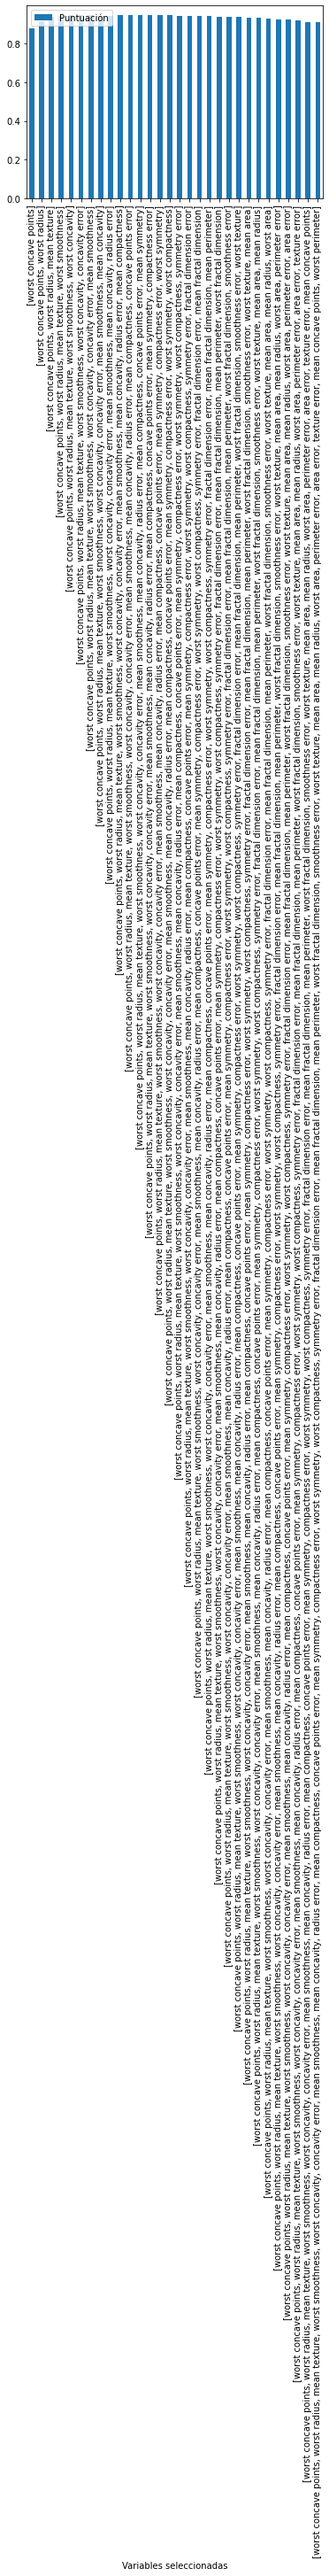

In [23]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

In [24]:
mean_variables_tumores=['mean radius','mean texture','mean perimeter','mean area','mean smoothness','mean compactness','mean concavity','mean concave points','mean symmetry','mean fractal dimension','diagnosis']
mean_datos_tumores_seleccionados = full_breast_cancer_cases[mean_variables_tumores]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(sequential_forward_selection(mean_datos_tumores_seleccionados),columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[mean concave points],1,0.833005
1,"[mean concave points, mean texture]",2,0.887861
2,"[mean concave points, mean texture, mean area]",3,0.911848
3,"[mean concave points, mean texture, mean area,...",4,0.917219
4,"[mean concave points, mean texture, mean area,...",5,0.918011
5,"[mean concave points, mean texture, mean area,...",6,0.918822
6,"[mean concave points, mean texture, mean area,...",7,0.919067
7,"[mean concave points, mean texture, mean area,...",8,0.913810
8,"[mean concave points, mean texture, mean area,...",9,0.909556
9,"[mean concave points, mean texture, mean area,...",10,0.910941


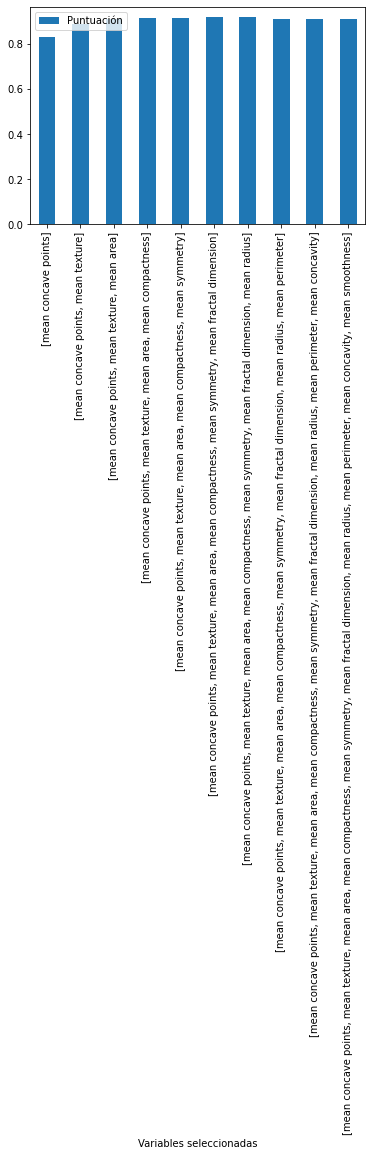

In [25]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

In [26]:
una_variable_tumores=['mean radius','diagnosis']
un_dato_tumor_seleccionado = full_breast_cancer_cases[una_variable_tumores]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(sequential_forward_selection(un_dato_tumor_seleccionado), columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[mean radius],1,0.791692


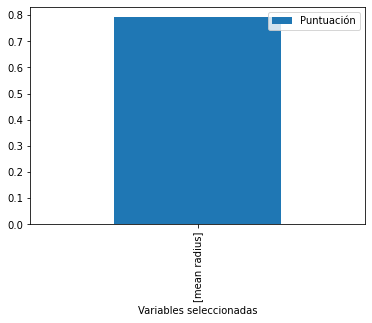

In [27]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

Como fenómeno a destacar en las pruebas podemos observar que la puntuación aumenta paulatinamente poco a poco conforme va añadiendo las mejores variables, para ir reduciendo su puntuación gradualmente con respecto se van introduciendo aquellas que son peores. Por otra parte, puede interpretarse como que este fenómeno aparece cuando se produce un sobre-entrenamiento debido a un exceso de variables, debido a que existen variables que introduzcan ruido o que, pese a realizar validación cruzada, existan casos sobre los que se realizan entrenamientos o evaluaciones erróneas porque sean incorrectos, aunque contaremos como que son correctos.

Por lo tanto, el conjunto de variables con mejor puntuación corresponden a los valores intermedios de la tabla, aunque debido a la dependencia de los resultados con respecto al conjunto de entrenamiento y pruebas, no nos permite descartar definitivamente el resto de variables, aunque sirven como orientación, y si deseamos reducir la complejidad de una función de aprendizaje, podríamos tomar el conjunto de variables que ofrezca una mayor puntuación, o que ofrezca un mejor promedio entre puntuación y tamaño.

### Pruebas de procedimientos individuales: Sequential Floating Forward Selection

Después de probar el método de búsqueda secuencial hacia adelante anterior, vamos a probar a ejecutar el método de búsqueda secuencial hacia adelante y atrás sobre los conjuntos de datos, para comprobar su funcionamiento básico.


#### Conjunto de datos: Titanic
Probaremos el conjunto completo, para ir a posteriori reduciendo el número de variables y comprobar sus resultados.

In [28]:
todas_variables = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Initial','Age_band','Family_Size','Alone','Fare_cat','Deck','Title','Is_Married','Survived']#
datos_titanic_seleccionados = full_titanic_passangers[todas_variables]

procesamiento = sequential_floating_forward_selection(datos_titanic_seleccionados)

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla=pandas.DataFrame(procesamiento, columns=nombres_columnas)

tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[Initial],1,0.783385
1,"[Initial, SibSp]",2,0.805224
2,"[Initial, SibSp, Deck]",3,0.807084
3,"[Initial, SibSp, Deck, Title]",4,0.809678
4,"[Initial, SibSp, Deck, Title, Fare_cat]",5,0.811354
5,"[Initial, SibSp, Deck, Title, Fare_cat, Sex]",6,0.811354
6,"[Initial, SibSp, Deck, Title, Fare_cat, Sex, I...",7,0.809905
7,"[Initial, SibSp, Deck, Title, Fare_cat, Sex, I...",8,0.811028
8,"[SibSp, Deck, Title, Fare_cat, Sex, Is_Married...",8,0.806651
9,"[SibSp, Deck, Title, Fare_cat, Sex, Is_Married...",8,0.801352


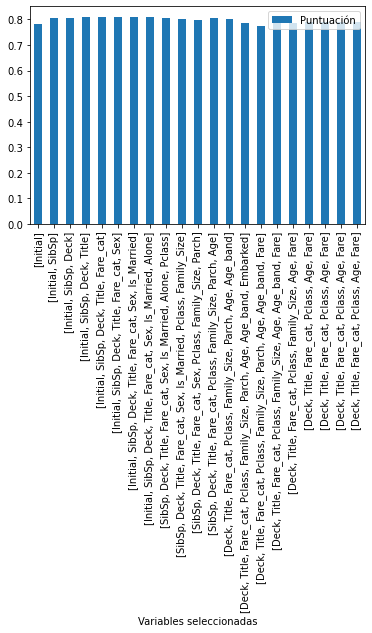

In [29]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

In [30]:
procesamiento

[[['Initial'], 1, 0.783384896621012],
 [['Initial', 'SibSp'], 2, 0.8052238722663885],
 [['Initial', 'SibSp', 'Deck'], 3, 0.807084274548199],
 [['Initial', 'SibSp', 'Deck', 'Title'], 4, 0.8096778574358996],
 [['Initial', 'SibSp', 'Deck', 'Title', 'Fare_cat'], 5, 0.8113544144132614],
 [['Initial', 'SibSp', 'Deck', 'Title', 'Fare_cat', 'Sex'],
  6,
  0.8113544144132614],
 [['Initial', 'SibSp', 'Deck', 'Title', 'Fare_cat', 'Sex', 'Is_Married'],
  7,
  0.8099051390509426],
 [['Initial',
   'SibSp',
   'Deck',
   'Title',
   'Fare_cat',
   'Sex',
   'Is_Married',
   'Alone'],
  8,
  0.8110281337033489],
 [['SibSp',
   'Deck',
   'Title',
   'Fare_cat',
   'Sex',
   'Is_Married',
   'Alone',
   'Pclass'],
  8,
  0.8066514650244911],
 [['SibSp',
   'Deck',
   'Title',
   'Fare_cat',
   'Sex',
   'Is_Married',
   'Pclass',
   'Family_Size'],
  8,
  0.8013515170001714],
 [['SibSp',
   'Deck',
   'Title',
   'Fare_cat',
   'Sex',
   'Pclass',
   'Family_Size',
   'Parch'],
  8,
  0.79988926904844

In [31]:
pocas_variables = ['Pclass','Sex','Age','SibSp','Parch','Fare','Survived']#
pocos_datos_titanic_seleccionados = full_titanic_passangers[pocas_variables]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla=pandas.DataFrame(sequential_floating_forward_selection(pocos_datos_titanic_seleccionados), columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[Sex],1,0.766818
1,"[Sex, Fare]",2,0.778832
2,"[Sex, Fare, Pclass]",3,0.788999
3,"[Sex, Fare, Pclass, Parch]",4,0.784319
4,"[Sex, Fare, Pclass, SibSp]",4,0.774115
5,"[Sex, Pclass, SibSp, Age]",4,0.783982
6,"[Sex, Pclass, SibSp, Age]",4,0.783982
7,"[Sex, Pclass, SibSp, Age]",4,0.783982
8,"[Sex, Pclass, SibSp, Age]",4,0.783982
9,"[Sex, Pclass, SibSp, Age]",4,0.783982


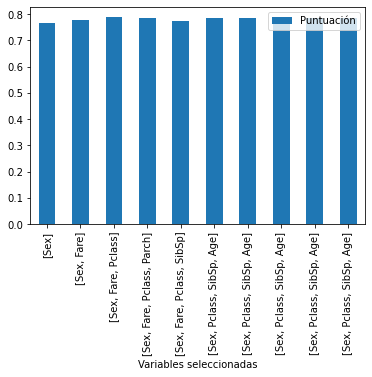

In [32]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

#### Conjunto de datos: Tumores
En segunda instancia, probaremos el conjunto completo, para ir a posteriori reduciendo el número de variables y comprobar sus resultados.

In [33]:
todas_variables_tumores=['mean radius','mean texture','mean perimeter','mean area','mean smoothness','mean compactness','mean concavity','mean concave points','mean symmetry','mean fractal dimension','radius error','texture error','perimeter error','area error','smoothness error','compactness error','concavity error','concave points error','symmetry error','fractal dimension error','worst radius','worst texture','worst perimeter','worst area','worst smoothness','worst compactness','worst concavity','worst concave points','worst symmetry','worst fractal dimension','diagnosis']
todos_datos_tumores_seleccionados = full_breast_cancer_cases[todas_variables_tumores]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla=pandas.DataFrame(sequential_floating_forward_selection(todos_datos_tumores_seleccionados), columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[worst concave points],1,0.878096
1,"[worst concave points, worst area]",2,0.912832
2,"[worst concave points, worst area, mean texture]",3,0.937731
3,"[worst concave points, worst area, mean textur...",4,0.944688
4,"[worst concave points, worst area, mean textur...",5,0.949375
5,"[worst concave points, worst area, mean textur...",6,0.949431
6,"[worst concave points, worst area, mean textur...",7,0.951334
7,"[worst concave points, mean texture, worst con...",7,0.947223
8,"[worst concave points, mean texture, worst con...",7,0.957504
9,"[worst concave points, mean texture, worst con...",8,0.956997


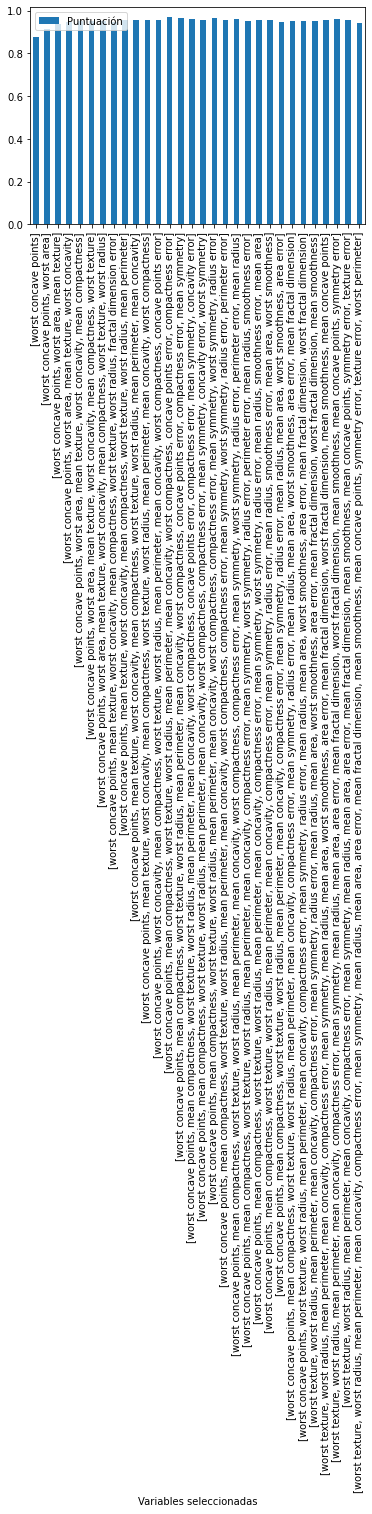

In [34]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

In [35]:
mean_variables_tumores=['mean radius','mean texture','mean perimeter','mean area','mean smoothness','mean compactness','mean concavity','mean concave points','mean symmetry','mean fractal dimension','diagnosis']
mean_datos_tumores_seleccionados = full_breast_cancer_cases[mean_variables_tumores]

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(sequential_floating_forward_selection(mean_datos_tumores_seleccionados), columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[mean concave points],1,0.843248
1,"[mean concave points, mean texture]",2,0.888037
2,"[mean concave points, mean texture, mean area]",3,0.914286
3,"[mean concave points, mean texture, mean area,...",4,0.917549
4,"[mean concave points, mean texture, mean area,...",5,0.921735
5,"[mean concave points, mean texture, mean area,...",6,0.917113
6,"[mean concave points, mean texture, mean area,...",6,0.929664
7,"[mean concave points, mean texture, mean area,...",6,0.914205
8,"[mean concave points, mean texture, mean area,...",6,0.919002
9,"[mean concave points, mean texture, mean area,...",7,0.917057


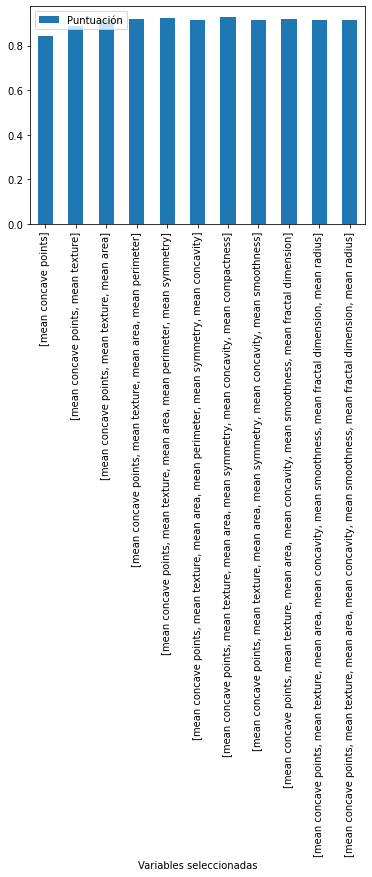

In [36]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

Experimentando con este método podemos observar un fenómeno similar al que ocurría en el anterior método. Observamos como el pico de soluciones no se encuentra en los casos en los que más tamaño registra, sino en aquellos en los que se encuentran las mejores soluciones. Para seleccionar las mejores variables deberíamos elegir aquellas que nos ofrezcan una mejor relación entre tamaño del conjunto de variables y su tasa de aciertos.

In [38]:
#Opcional, script que deshabilita hacer scrolling para visualizar los resultados
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

SyntaxError: invalid syntax (<ipython-input-38-8c8d0113a19d>, line 3)

## Otros conjuntos de datos

Para probar la eficacia de los algoritmos desarrollados, hemos decidido probar a aplicar el algoritmo a otros conjuntos de datos obtenidos con el mismo formato que los expuestos anteriormente. Probaremos los algoritmos SFS y SFFS y de evaluación, para comparar con los anteriores conjuntos.

En primer lugar, probaremos resultados con un conjunto de datos que corresponde a un problema de clasificación por clases y otro, binaria para analizar los resultados.

### Conjunto de datos multi-clase. Clasificación de vinos

Este conjunto busca realizar una predicción de la calidad de vinos blancos en una escala de mediciones y componentes químicas de cada vino, uno por entrada del archivo. Ofrece 4898 observaciones con 11 variables y 1 variable de salida, con un problema de clasificación de tipo clasificación multi-clase. Las variables que lo componen son:

    Fixed acidity.
    Volatile acidity.
    Citric acid.
    Residual sugar.
    Chlorides.
    Free sulfur dioxide.
    Total sulfur dioxide.
    Density.
    pH.
    Sulphates.
    Alcohol.
    Quality (score between 0 and 10).


En primer lugar, importamos el conjunto de datos que vamos a utilizar, para posteriormente, evaluar el acierto del conjunto completo de variables.

In [39]:
full_wine = pandas.read_csv('vino.csv', header=0)

In [41]:
todas_variables_vino=['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
print(evaluar_solucion_paralelizada(full_wine, todas_variables_vino, 20, 10))

0.23619416019235928


A continuación, probamos la ejecución del algotitmo SFS, con una gráfica que ilustra el grado de acierto de cada conjunto de variables que ha seleccionado el algoritmo tal y como hicimos en los conjuntos anteriores.

In [42]:
todas_variables_vino_mas_solucion=['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']
datos_vino_seleccionados = full_wine[todas_variables_vino_mas_solucion]

procesamiento = sequential_forward_selection(datos_vino_seleccionados)
nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(procesamiento, columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[alcohol],1,0.210655
1,"[alcohol, free sulfur dioxide]",2,0.234990
2,"[alcohol, free sulfur dioxide, total sulfur di...",3,0.238423
3,"[alcohol, free sulfur dioxide, total sulfur di...",4,0.235703
4,"[alcohol, free sulfur dioxide, total sulfur di...",5,0.255889
5,"[alcohol, free sulfur dioxide, total sulfur di...",6,0.251705
6,"[alcohol, free sulfur dioxide, total sulfur di...",7,0.253199
7,"[alcohol, free sulfur dioxide, total sulfur di...",8,0.253281
8,"[alcohol, free sulfur dioxide, total sulfur di...",9,0.248235
9,"[alcohol, free sulfur dioxide, total sulfur di...",10,0.245620


In [44]:
procesamiento

[[['alcohol'], 1, 0.2106554529027367],
 [['alcohol', 'free sulfur dioxide'], 2, 0.2349898021372466],
 [['alcohol', 'free sulfur dioxide', 'total sulfur dioxide'],
  3,
  0.23842292507246385],
 [['alcohol',
   'free sulfur dioxide',
   'total sulfur dioxide',
   'volatile acidity'],
  4,
  0.23570259905127952],
 [['alcohol',
   'free sulfur dioxide',
   'total sulfur dioxide',
   'volatile acidity',
   'residual sugar'],
  5,
  0.25588904299725845],
 [['alcohol',
   'free sulfur dioxide',
   'total sulfur dioxide',
   'volatile acidity',
   'residual sugar',
   'sulphates'],
  6,
  0.25170464786879543],
 [['alcohol',
   'free sulfur dioxide',
   'total sulfur dioxide',
   'volatile acidity',
   'residual sugar',
   'sulphates',
   'pH'],
  7,
  0.25319863229379674],
 [['alcohol',
   'free sulfur dioxide',
   'total sulfur dioxide',
   'volatile acidity',
   'residual sugar',
   'sulphates',
   'pH',
   'citric acid'],
  8,
  0.2532814333881994],
 [['alcohol',
   'free sulfur dioxide',
 

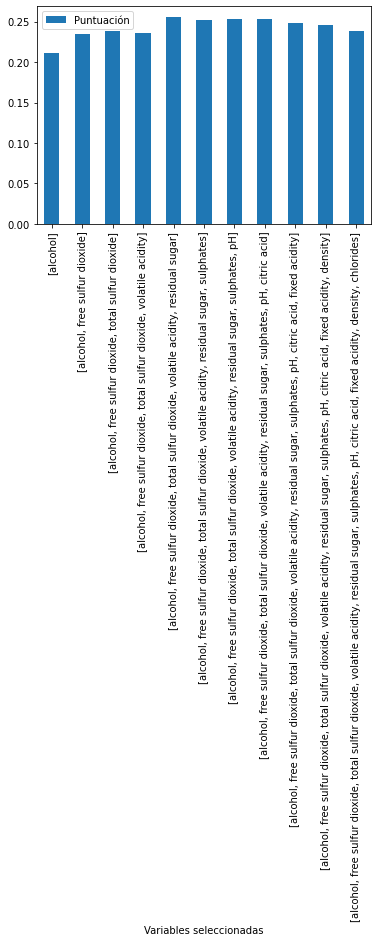

In [43]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

Para finalizar, realizamos la ejecución del algoritmo SFFS al conjunto.

In [45]:
todas_variables_vino_mas_solucion=['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']
datos_vino_seleccionados = full_wine[todas_variables_vino_mas_solucion]

procesamiento = sequential_floating_forward_selection(datos_vino_seleccionados)

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla=pandas.DataFrame(procesamiento, columns=nombres_columnas)

tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[alcohol],1,0.194883
1,"[alcohol, free sulfur dioxide]",2,0.211888
2,"[alcohol, free sulfur dioxide, volatile acidity]",3,0.222156
3,"[alcohol, free sulfur dioxide, volatile acidit...",4,0.231203
4,"[alcohol, free sulfur dioxide, volatile acidit...",5,0.240571
5,"[alcohol, free sulfur dioxide, volatile acidit...",5,0.239116
6,"[alcohol, free sulfur dioxide, volatile acidit...",6,0.237569
7,"[alcohol, free sulfur dioxide, volatile acidit...",7,0.231912
8,"[alcohol, free sulfur dioxide, volatile acidit...",7,0.230996
9,"[alcohol, free sulfur dioxide, volatile acidit...",7,0.221957


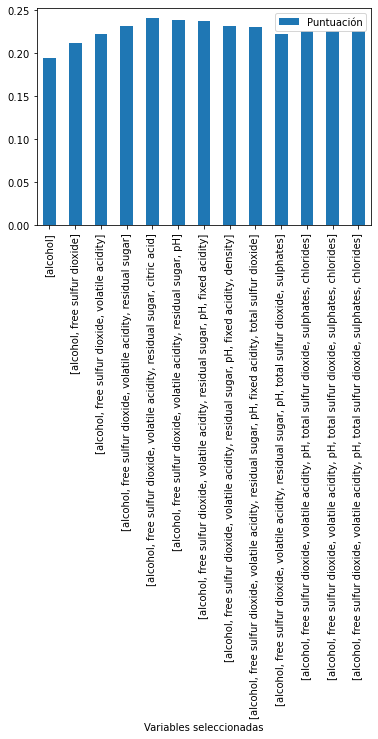

In [46]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

### Conjunto de datos de decisión. Clasificación de diagnóstico de diabetes

Se trata de un conjunto de datos que predice la aparición de diabetes en el pueblo Indio Pima, localizado en Arizona, y que concierne en la predicción en base a criterios médicos a lo largo de 5 años. 

Se trata de un problema de clasificación binaria, con un número de observaciones no balanceado, con 768 observaciones y  8 variables de entrada y 1 de salida. Los valores a 0 corresponden a valores no disponibles y algunos que corresponden a dicho valor. El listado de variables es:

    Number of times pregnant.
    Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
    Diastolic blood pressure (mm Hg).
    Triceps skinfold thickness (mm).
    2-Hour serum insulin (mu U/ml).
    Body mass index (weight in kg/(height in m)^2).
    Diabetes pedigree function.
    Age (years).
    Class variable (0 or 1).

En primer lugar, importamos el conjunto de datos que vamos a utilizar, para posteriormente, evaluar el acierto del conjunto completo de variables.

In [51]:
full_diabetes = pandas.read_csv('pima-indians-diabetes.csv', header=0)

In [52]:
todas_variables_diabetes=['Times pregnant','Plasma glucose','blood pressure','Triceps skinfold thickness','2-Hour serum insulin','Body mass index','Diabetes pedigree','Age']
print(evaluar_solucion_paralelizada(full_diabetes, todas_variables_diabetes, 20, 10))

0.6694814814814815


A continuación, probamos la ejecución del algotitmo SFS, con una gráfica que ilustra el grado de acierto de cada conjunto de variables que ha seleccionado el algoritmo tal y como hicimos en los conjuntos anteriores.


In [54]:
todas_variables_diabetes_mas_solucion=['Times pregnant','Plasma glucose','blood pressure','Triceps skinfold thickness','2-Hour serum insulin','Body mass index','Diabetes pedigree','Age','Class']
datos_diabetes_seleccionados = full_diabetes[todas_variables_diabetes_mas_solucion]

procesamiento = sequential_forward_selection(datos_diabetes_seleccionados)
nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla = pandas.DataFrame(procesamiento, columns=nombres_columnas)
tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[Plasma glucose],1,0.629373
1,"[Plasma glucose, Body mass index]",2,0.667589
2,"[Plasma glucose, Body mass index, Age]",3,0.651998
3,"[Plasma glucose, Body mass index, Age, Diabete...",4,0.672086
4,"[Plasma glucose, Body mass index, Age, Diabete...",5,0.678372
5,"[Plasma glucose, Body mass index, Age, Diabete...",6,0.672571
6,"[Plasma glucose, Body mass index, Age, Diabete...",7,0.668110
7,"[Plasma glucose, Body mass index, Age, Diabete...",8,0.672521


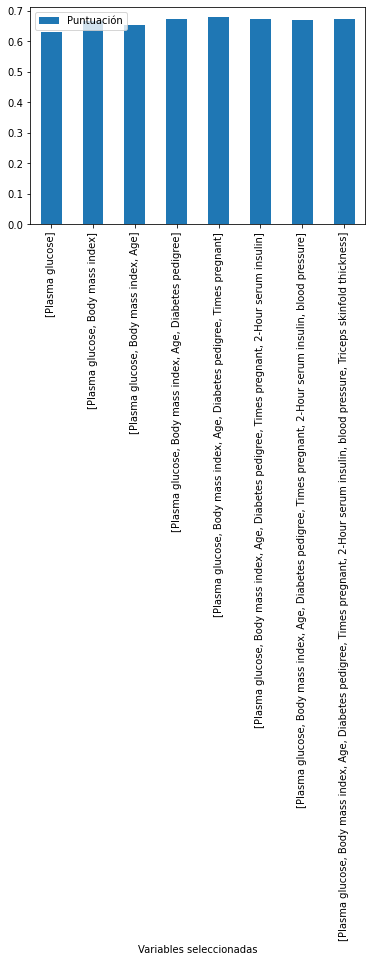

In [55]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')

Para finalizar, realizamos la ejecución del algoritmo SFFS al conjunto.

In [56]:
todas_variables_diabetes_mas_solucion=['Times pregnant','Plasma glucose','blood pressure','Triceps skinfold thickness','2-Hour serum insulin','Body mass index','Diabetes pedigree','Age','Class']
datos_diabetes_seleccionados = full_diabetes[todas_variables_diabetes_mas_solucion]

procesamiento = sequential_floating_forward_selection(datos_diabetes_seleccionados)

nombres_columnas=['Variables seleccionadas', 'Tamaño', 'Puntuación']
tabla=pandas.DataFrame(procesamiento, columns=nombres_columnas)

tabla

,Variables seleccionadas,Tamaño,Puntuación
0,[Plasma glucose],1,0.640494
1,"[Plasma glucose, Diabetes pedigree]",2,0.659683
2,"[Plasma glucose, Diabetes pedigree, Body mass ...",3,0.683411
3,"[Plasma glucose, Diabetes pedigree, Body mass ...",4,0.670160
4,"[Plasma glucose, Diabetes pedigree, Body mass ...",4,0.676195
5,"[Plasma glucose, Body mass index, Times pregna...",4,0.673236
6,"[Plasma glucose, Body mass index, Times pregna...",5,0.683384
7,"[Plasma glucose, Body mass index, Times pregna...",6,0.685352
8,"[Plasma glucose, Body mass index, Times pregna...",6,0.685352


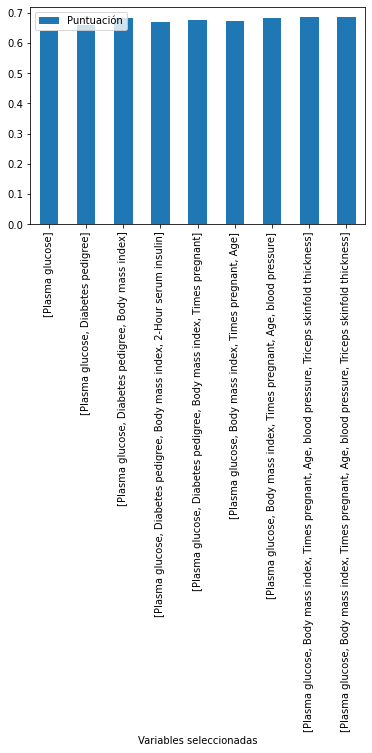

In [57]:
tabla.plot(kind='bar',x='Variables seleccionadas',y='Puntuación')